In [32]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os

In [33]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [34]:
!pip install tensorflow_hub

In [35]:
import PIL
import PIL.Image
from pathlib import Path
import matplotlib.pyplot as plt
import time
import PIL.Image as Image
import tensorflow_hub as hub
import datetime
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [54]:
data_dir = os.path.join('data_5')
list_ds = tf.data.Dataset.list_files(data_dir + "/*/*.jpg", shuffle=False)

In [55]:
image_count=tf.data.experimental.cardinality(list_ds).numpy()

In [56]:
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)


In [57]:
class_names = np.array(sorted([item.name for item in Path(data_dir).glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['awake' 'sleep']


In [58]:
print(tf.data.experimental.cardinality(list_ds).numpy())


3720


In [59]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [60]:
train_ds

<SkipDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [61]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [62]:
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [224, 224])

In [63]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [64]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path)
val_ds = val_ds.map(process_path)



In [65]:
train_ds= train_ds.batch(10, drop_remainder=True)
val_ds=val_ds.batch(10, drop_remainder=True)

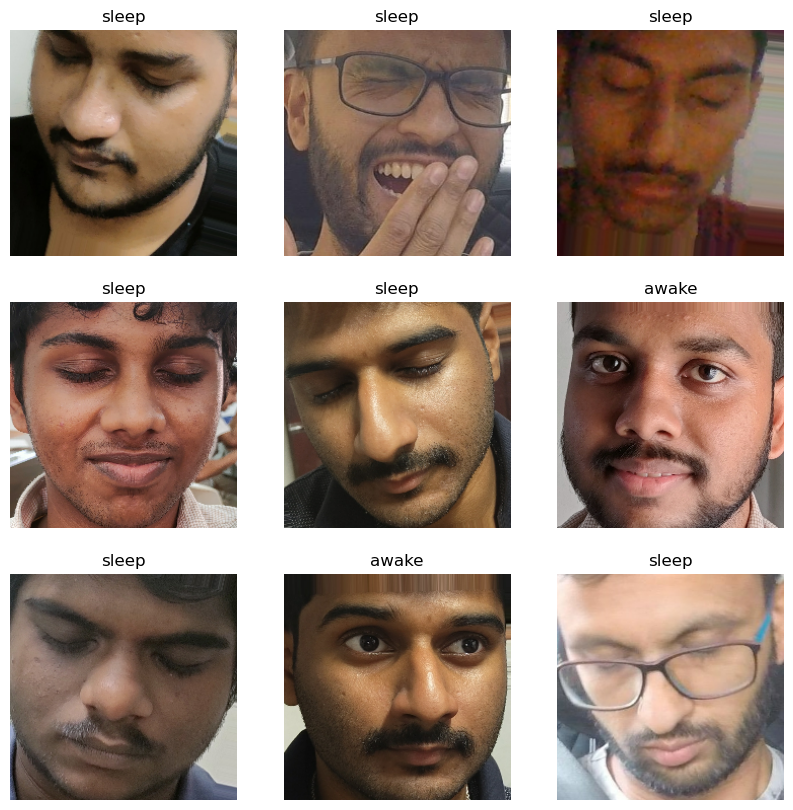

In [66]:
import matplotlib.pyplot as plt

image_batch, label_batch = train_ds.as_numpy_iterator().next()
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")
    

In [67]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [68]:
for x, y in train_ds.take(1):
    print("x:", x.numpy())
    print("y:", y.numpy())

x: [[[[0.82745105 0.8470589  0.8313726 ]
   [0.82745105 0.8470589  0.8313726 ]
   [0.82745105 0.8470589  0.8313726 ]
   ...
   [0.369091   0.3573263  0.32203218]
   [0.41637453 0.40460983 0.3730447 ]
   [0.34213075 0.33036605 0.29918608]]

  [[0.82745105 0.8470589  0.8313726 ]
   [0.82745105 0.8470589  0.8313726 ]
   [0.82745105 0.8470589  0.8313726 ]
   ...
   [0.39201707 0.37858045 0.3399425 ]
   [0.3500638  0.3382991  0.31084812]
   [0.36903697 0.35560036 0.32030624]]

  [[0.82745105 0.8470589  0.8313726 ]
   [0.82745105 0.8470589  0.8313726 ]
   [0.8235295  0.8431373  0.82745105]
   ...
   [0.36843267 0.3527464  0.30960914]
   [0.37869504 0.365451   0.3301569 ]
   [0.34778583 0.33209956 0.28896227]]

  ...

  [[0.05882353 0.05490196 0.03921569]
   [0.05490196 0.05882353 0.03921569]
   [0.04557948 0.04950105 0.02989321]
   ...
   [0.06758792 0.08719576 0.06366635]
   [0.06666667 0.08627451 0.0627451 ]
   [0.07129146 0.0791346  0.05952675]]

  [[0.05695904 0.05303747 0.03735119]
   [

In [69]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [70]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(10, 224, 224, 3)
(10,)


In [73]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
BiT_M_R101x3_model="https://tfhub.dev/google/bit/m-r101x3/imagenet21k_classification/1"
imagenet21k="imagenet_efficientnet_v2_imagenet21k_ft1k_l_classification_2.tar.gz"
feature_extractor_model = mobilenet_v2


In [74]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [75]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(10, 1280)


In [76]:
num_classes = len(class_names)
model = tf.keras.Sequential([
  feature_extractor_layer,
      tf.keras.layers.Dense(num_classes,activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
Total params: 2,260,552
Trainable params: 2,568
Non-trainable params: 2,257,984
_________________________________________________________________


In [77]:
predictions = model(image_batch)


In [78]:
predictions.shape

TensorShape([10, 2])

In [79]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [84]:
NUM_EPOCHS = 1
class_weights = {0: 1, 1: 5}
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=[callback],class_weight=class_weights)

297/297 [==============================] - 39s 130ms/step - loss: 0.1791 - acc: 0.9717 - val_loss: 0.1779 - val_acc: 0.9486


In [85]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[np.argmax(predicted_batch, axis=-1).flatten()]
print(predicted_label_batch)

1/1 [==============================] - 2s 2s/step
['sleep' 'sleep' 'sleep' 'sleep' 'sleep' 'awake' 'sleep' 'awake' 'sleep'
 'sleep']


In [86]:
predicted_batch[0].max()

8.961264

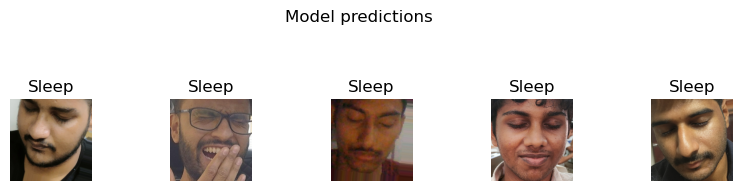

In [87]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(5):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_label_batch[n].title())
    plt.axis('off')
_ = plt.suptitle("Model predictions")

In [88]:
t = time.time()

export_path = "{}".format(int(t))
model.save(export_path)

export_path

'1682574935'

In [39]:
reloaded = tf.keras.models.load_model('1681389804')



KeyboardInterrupt



In [41]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 2s 2s/step


In [42]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [47]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[np.argmax(reloaded_result_batch, axis=-1).flatten()]
print(reloaded_predicted_label_batch)

['sleep' 'awake' 'sleep' 'sleep' 'sleep' 'awake' 'sleep' 'sleep' 'sleep'
 'awake']


In [46]:
reloaded_predicted_id

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 0, 1, 1, 1, 0, 1, 1, 1, 0], dtype=int64)>